In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [2]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats
from loading import load_session_data
from target import get_spike_counts, build_silence_and_noise_events, \
        get_idxs_of_event_periods, get_spike_times_at
np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

In [5]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
session  = sessions[0]
animal   = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
aeps_file = os.path.join(dst_path, animal, session, 'analysis', 'AEP_components.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    #trials       = np.array(f['processed']['trial_idxs'])
    #cfg          = json.loads(f['processed'].attrs['parameters'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])
    
# load AEP metrics
AEP_metrics = {}
with h5py.File(aeps_file, 'r') as f:
    for area in f:
        metrics = {}
        for m in f[area]:
            metrics[m] = np.array(f[area][m])
        AEP_metrics[area] = metrics

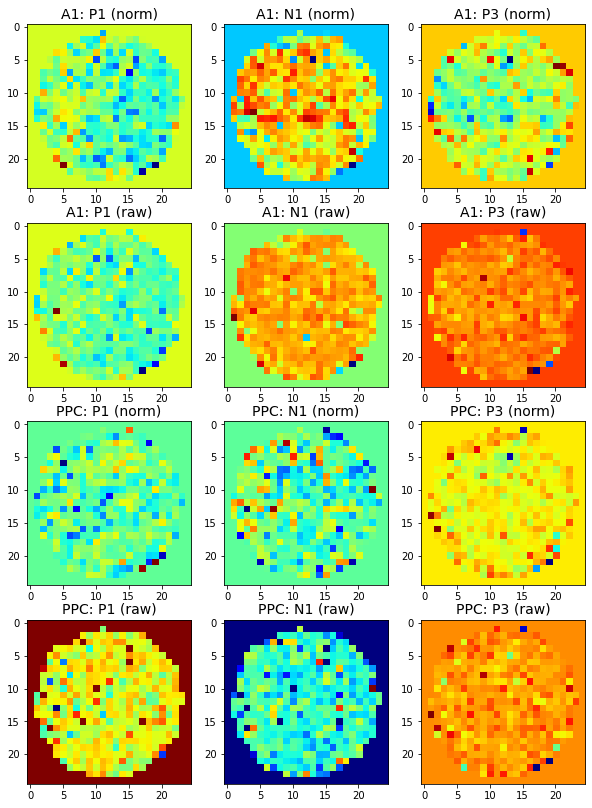

In [96]:
to_plot = ['P1', 'N1', 'P3']
sigma = 0.5
bin_size = 0.04
x_min, x_max = -0.5, 0.5
y_min, y_max = -0.5, 0.5

x_range = x_max - x_min
y_range = y_max - y_min
y_bin_count = int(np.ceil(y_range / bin_size))
x_bin_count = int(np.ceil(x_range / bin_size))

# filter, e.g. BGR + TGT only
idxs_filt = np.where( (sound_events[:, 1] == 1) | (sound_events[:, 1] == 2) )[0]

# positions where AEPs happened
x_pos = tl[sound_events[idxs_filt][:, 2].astype(np.int32)][:, 1]
y_pos = tl[sound_events[idxs_filt][:, 2].astype(np.int32)][:, 2]

def get_aep_map(metric):
    aep_map = np.zeros([x_bin_count, y_bin_count])
    for x_bin_idx in range(x_bin_count - 1):
        for y_bin_idx in range(y_bin_count - 1):
            x_l = x_min + bin_size * x_bin_idx
            x_r = x_min + bin_size * (x_bin_idx + 1)
            y_l = y_min + bin_size * y_bin_idx
            y_r = y_min + bin_size * (y_bin_idx + 1)

            # select all AEP responses in that bin
            x_idxs = np.where( (x_pos > x_l) & (x_pos < x_r) )[0]
            y_idxs = np.where( (y_pos > y_l) & (y_pos < y_r) )[0]
            sel_idxs = np.intersect1d(x_idxs, y_idxs)
            if len(sel_idxs) > 0:
                aep_map[x_bin_idx, y_bin_idx] = metric[sel_idxs].mean()
    return aep_map

# plotting
cols = len(to_plot)
rows = 2 * len(AEP_metrics)
fig = plt.figure(figsize=(10, rows*3.5))

for i, (area, metrics) in enumerate(AEP_metrics.items()):
    for j, m_type in enumerate(['norm', 'raw']):
        for k, m_name in enumerate(to_plot):
            m_vals = metrics['%s_%s' % (m_name, m_type)]
            aep_map = get_aep_map(m_vals[idxs_filt])
            
            ax = fig.add_subplot(rows, cols, 6*i + 3*j + k + 1)
            ax.imshow(aep_map, cmap='jet')
            ax.set_title("%s: %s (%s)" % (area, m_name, m_type), fontsize=14)